In [29]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import datetime

import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### ERA5

In [10]:
gdf = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')

In [11]:
US = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')

regions_dict = {
    'NE': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV'],
    'Midwest': ['IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH'],
    'SE': ['AL', 'FL', 'GA', 'NC', 'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS'],
    'NGP': ['MT', 'NE', 'ND', 'SD', 'WY'],
    'SGP': ['KS', 'OK', 'TX'],
    'SW': ['AZ', 'CO', 'NM', 'UT', 'CA', 'NV'],
    'NW': ['ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}

In [12]:
ds_era = xr.open_dataset('/N/project/Zli_lab/amulla/JJA/ERA5_land_data_recalculated/Hourly_Total_Precipitation_T_092022.nc')

In [13]:
ds_era_lon, ds_era_lat = np.meshgrid(ds_era.longitude.values, ds_era.latitude.values, indexing='xy')

In [6]:
# 转换为 xarray DataArray，确保其维度与 ds_era_clipped 对齐
ds_era_lon_da = xr.DataArray(ds_era_lon, dims=("latitude", "longitude"), coords={"latitude": ds_era.latitude, "longitude": ds_era.longitude})
ds_era_lat_da = xr.DataArray(ds_era_lat, dims=("latitude", "longitude"), coords={"latitude": ds_era.latitude, "longitude": ds_era.longitude})

# 使用 assign_coords 将二维坐标添加到 ds_era_clipped
ds_era_clipped = ds_era.assign_coords(lon_2d=ds_era_lon_da, lat_2d=ds_era_lat_da)

In [7]:

lon = ds_era_clipped['lon_2d'].values
lat = ds_era_clipped['lat_2d'].values
grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()),
    index=np.arange(lon.size)
)
grid.set_crs(gdf.crs, inplace=True)
grid_s = gpd.sjoin(grid, gdf, how='inner', predicate='within')

mask = np.full(ds_era_clipped['tp'].shape[1:], False) 
for index in grid_s.index:
    row, col = np.unravel_index(index, mask.shape)  # 获取行列索引
    mask[row, col] = True
mask_da = xr.DataArray(mask, dims=ds_era_clipped['tp'].dims[1:], coords={'latitude': ds_era_clipped['tp'].coords['latitude'], 'longitude': ds_era_clipped['tp'].coords['longitude']})
ds_conus = ds_era_clipped.where(mask_da, drop=True)

In [8]:
output_folder = '/N/project/Zli_lab/gongg/CONUS404_data/LST/re_UTC/U' + str(offset)+str(i) + '/'

NameError: name 'offset' is not defined

In [9]:
ds_conus_cleaned = ds_conus.drop_vars(["lon_2d", "lat_2d"])

# 选择 time = "2021-07-31T23:00:00.000000000"
selected_time = "2022-09-30T23:00:00.000000000"
ds_selected = ds_conus_cleaned.sel(time=selected_time)

# 显示处理后的数据集
ds_selected

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 249, longitude: 580)
Coordinates:
    time       datetime64[ns] 8B 2022-09-30T23:00:00
  * longitude  (longitude) float32 2kB -124.8 -124.7 -124.6 ... -67.0 -66.9
  * latitude   (latitude) float32 996B 49.3 49.2 49.1 49.0 ... 24.7 24.6 24.5
Data variables:
    tp         (latitude, longitude) float64 1MB nan nan nan nan ... nan nan nan

In [10]:
# 保留 time 维度，但仍然选择特定时间
ds_selected = ds_conus_cleaned.sel(time="2022-09-30T23:00:00.000000000").expand_dims("time")

# 显示结果
ds_selected

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 1, latitude: 249, longitude: 580)
Coordinates:
  * time       (time) datetime64[ns] 8B 2022-09-30T23:00:00
  * longitude  (longitude) float32 2kB -124.8 -124.7 -124.6 ... -67.0 -66.9
  * latitude   (latitude) float32 996B 49.3 49.2 49.1 49.0 ... 24.7 24.6 24.5
Data variables:
    tp         (time, latitude, longitude) float64 1MB nan nan nan ... nan nan

In [11]:
ds_selected.to_netcdf('era_refer_202209302300.nc')

In [28]:
np.nanmin(ds_selected.tp.values)

-3.1888484954833984e-06

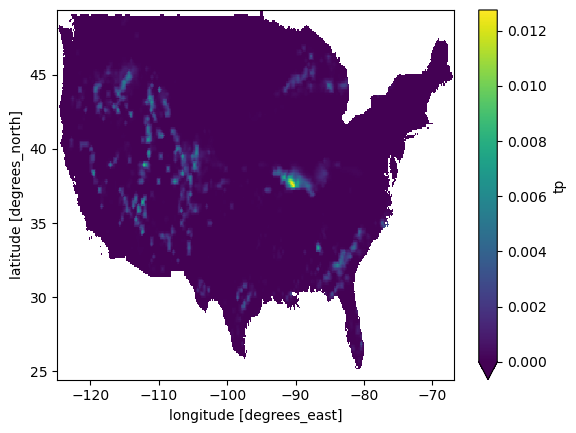

In [27]:
ds_selected.mean('time').tp.plot(cmap = 'viridis', vmin=0.00)
plt.show()

### CONUS404

In [10]:
ds_404 = xr.open_dataset('/N/project/Zli_lab/Data/Observations/NCAR/prec_acc_files/PREC_ACC_NC.wrf2d_d01_2022-09-30_23:00:00.nc')

In [23]:
regions_dict = {
    'CONUS': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV',
    'IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH', 'AL', 'FL', 'GA', 'NC', 
    'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS', 'MT', 'NE', 'ND', 'SD', 'WY', 
    'KS', 'OK', 'TX', 'AZ', 'CO', 'NM', 'UT', 'CA', 'NV', 'ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}

In [25]:

US = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')
regions_dict = {
    'CONUS': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV',
              'IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH', 'AL', 'FL', 'GA', 'NC', 'SC', 'VA', 
              'TN', 'KY', 'AR', 'LA', 'MS', 'MT', 'NE', 'ND', 'SD', 'WY', 'KS', 'OK', 'TX', 'AZ', 
              'CO', 'NM', 'UT', 'CA', 'NV', 'ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}


# 获取 XLAT 和 XLONG 并转换为 DataFrame
lon = ds_404['XLONG'].values  # shape: (1015, 1367)
lat = ds_404['XLAT'].values   # shape: (1015, 1367)

# 创建 GeoDataFrame（将 XLONG 和 XLAT 转换为点）
grid_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()), 
    index=pd.MultiIndex.from_product([range(lon.shape[0]), range(lon.shape[1])], names=['south_north', 'west_east'])
)
grid_points.set_crs(regions['CONUS'].crs, inplace=True)  # 设置 CRS 与 shapefile 一致

# 进行空间连接，筛选 CONUS 内的点
grid_filtered = gpd.sjoin(grid_points, regions['CONUS'], how='inner', predicate='within')

# 创建 xarray 掩码
mask = np.full((lon.shape[0], lon.shape[1]), False)  # 初始化全 False
for (row, col) in grid_filtered.index:
    mask[row, col] = True  # 标记落入区域的点为 True

# 转换为 xarray DataArray
mask_da = xr.DataArray(mask, dims=('south_north', 'west_east'), coords={'south_north': ds_404['south_north'], 'west_east': ds_404['west_east']})

# 只保留 CONUS 内的降水数据
ds_filtered = ds_404.where(mask_da, drop=True)



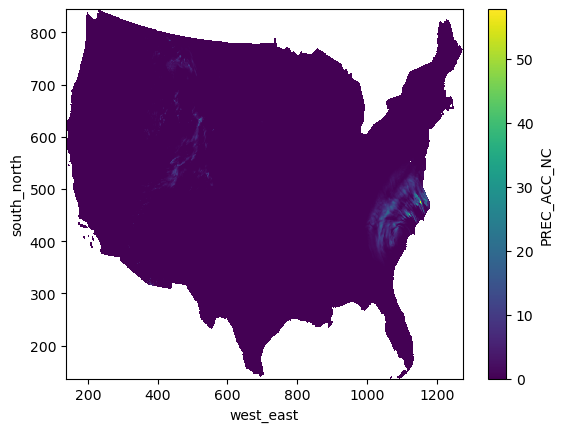

In [27]:
ds_filtered.mean('Time').PREC_ACC_NC.plot()
plt.show()

In [2]:
ds11 = xr.open_dataset('remapping/remapp_404_202209302300.nc')

In [8]:
ds11

<xarray.Dataset> Size: 2MB
Dimensions:                (time: 1, latitude: 249, longitude: 580, Time: 1)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2022-09-30T23:00:00
  * longitude              (longitude) float32 2kB -124.8 -124.7 ... -67.0 -66.9
  * latitude               (latitude) float32 996B 49.3 49.2 49.1 ... 24.6 24.5
  * Time                   (Time) datetime64[ns] 8B 2022-09-30T23:00:00
    XTIME                  (Time) datetime64[ns] 8B ...
Data variables:
    tp                     (time, latitude, longitude) float64 1MB nan ... nan
    PREC_ACC_NC_regridded  (Time, latitude, longitude) float32 578kB ...

In [15]:
arr_era = ds11.tp.values

In [16]:
arr_404 = ds11.PREC_ACC_NC_regridded.values

In [18]:
arr_era.shape

(1, 249, 580)

In [19]:
arr_404.shape

(1, 249, 580)

In [20]:

mask = ~np.isnan(arr_era)  # 只保留有效数据区域

# 使用 mask 进行裁剪
arr_404_ = np.where(mask, arr_404, np.nan)  # 让 arr_404 仅保留 arr_era 的有效区域


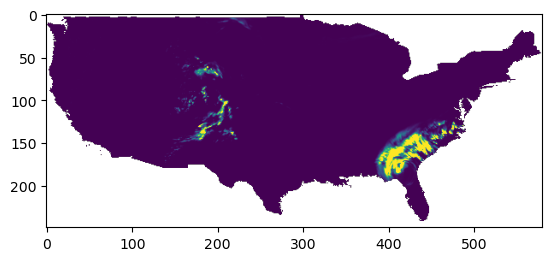

In [27]:
plt.imshow(arr_404_[0],vmax=5,vmin=0)
plt.show()


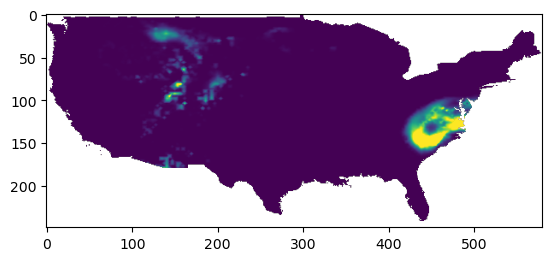

In [28]:
plt.imshow(arr_era[0]*1000,vmax=5,vmin=0)
plt.show()